In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score

In [2]:
train_df = pd.read_feather('../input/train.f')
test_df = pd.read_feather('../input/test.f')
print('train_df', train_df.shape)
print('test_df', test_df.shape)

train_feat_df = pd.read_feather('../input/train_feat_df.f')
test_feat_df = pd.read_feather('../input/test_feat_df.f')
print('train_feat_df', train_feat_df.shape)
print('test_feat_df', test_feat_df.shape)

train_df (1997595, 35)
test_df (390095, 30)
train_feat_df (1997595, 57)
test_feat_df (390095, 57)


In [3]:
whole_feat_df = pd.concat([train_feat_df, test_feat_df], ignore_index=True)
adv_target_labl = [True] * len(train_df) + [False] * len(test_df)
adv_target_labl = np.array(adv_target_labl)

In [4]:
def pr_auc(y_true, y_pred):
    """lightGBM の round ごとに PR-AUC を計算する用"""
    score = average_precision_score(y_true, y_pred)
    return "pr_auc", score, True

def fit_lgbm(X, y, cv, params: dict=None, verbose=100):

    # パラメータがないときはからの dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)

#         with timer(prefix='fit fold={} '.format(i + 1)):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=verbose, 
                eval_metric=pr_auc,
                verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} PR-AUC: {average_precision_score(y_valid, pred_i):.4f}')

    score = average_precision_score(y, oof_pred)
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

In [5]:
adv_params = {
    'n_estimators': 100
}

adv_cv = StratifiedKFold(shuffle=True, random_state=71).split(whole_feat_df, adv_target_labl)
adv_oof, adv_models = fit_lgbm(whole_feat_df.values, 
                               y=adv_target_labl, 
                               cv=adv_cv, 
                               params=adv_params)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.113908	valid_0's pr_auc: 0.998076
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.113908	valid_0's pr_auc: 0.998076
Fold 0 PR-AUC: 0.9981
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.114189	valid_0's pr_auc: 0.998155
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.114189	valid_0's pr_auc: 0.998155
Fold 1 PR-AUC: 0.9982
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.115514	valid_0's pr_auc: 0.998036
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.115514	valid_0's pr_auc: 0.998036
Fold 2 PR-AUC: 0.9980
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.116275	valid_0's pr_auc: 0.997976
Did not meet early stopping. Best iteration is:
[100]	valid_0's bi

In [6]:
roc_auc_score(adv_target_labl, adv_oof)

0.9904602435494448

In [7]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .mean()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(7, len(order) * .2))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax, palette='viridis')
    ax.grid()
    fig.tight_layout()
    return fig, ax

(<Figure size 504x820.8 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9750fdc880>)

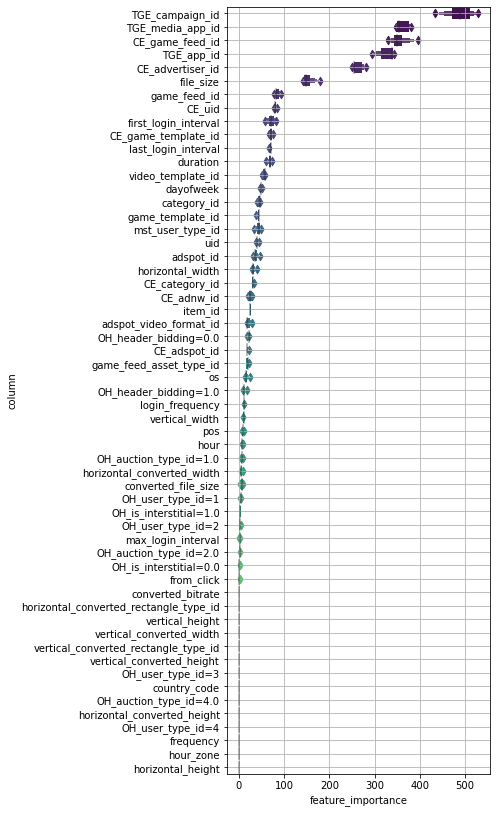

In [8]:
visualize_importance(adv_models, whole_feat_df)